# Futures Hedging Simulation
This notebook simulates hedging with futures as described in `01_Hedging_Futures.md`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Data Acquisition & Preprocessing

In [5]:
# Load spot and futures data with proper parsing
spot = pd.read_csv('NIFTY_spot.csv', parse_dates=['Date'], index_col='Date', thousands=',')
futures = pd.read_csv('NIFTY_futures.csv', parse_dates=['Date'], index_col='Date', thousands=',')

# Extract only 'Close' column, ensure float type
spot = spot['Close'].astype(float)
futures = futures['Price'].astype(float)

# Merge into single dataframe
df = pd.DataFrame({'Spot': spot, 'Futures': futures}).dropna()

# Calculate daily returns
df['Spot_Returns'] = df['Spot'].pct_change()
df['Futures_Returns'] = df['Futures'].pct_change()

# Drop initial NaN from returns
df = df.dropna()

# Preview
df.head()


C:\Users\Vatsh Van\AppData\Local\Temp\ipykernel_29608\2944716916.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  spot = pd.read_csv('NIFTY_spot.csv', parse_dates=['Date'], index_col='Date', thousands=',')


,Spot,Futures,Spot_Returns,Futures_Returns
Date,,,,
2024-07-02,24123.85,24319.05,-0.000750,0.000327
2024-07-03,24286.50,24462.50,0.006742,0.005899
2024-07-04,24302.15,24471.00,0.000644,0.000347
2024-07-05,24323.85,24497.25,0.000893,0.001073
2024-07-08,24320.55,24493.35,-0.000136,-0.000159


## 2. Hedge Ratio Calculation

In [6]:
sigma_S = df['Spot_Returns'].std()
sigma_F = df['Futures_Returns'].std()
rho = df['Spot_Returns'].corr(df['Futures_Returns'])

h_star = (sigma_S / sigma_F) * rho
print('Optimal Hedge Ratio:', round(h_star, 3))

Optimal Hedge Ratio: 0.985


## 3. Hedge Simulation

In [7]:
# Assume exposure size
exposure = 1_000_000  # INR
contract_size = 75

# Calculate number of futures contracts
futures_position = h_star * exposure / (df['Futures'].iloc[-1] * contract_size)
print('Futures Contracts:', round(futures_position))

# Hedged P&L
df['Hedged_PnL'] = exposure * df['Spot_Returns'] - futures_position * contract_size * df['Futures_Returns']
df['Cumulative_Hedged_PnL'] = df['Hedged_PnL'].cumsum()
df.head()

Futures Contracts: 1


,Spot,Futures,Spot_Returns,Futures_Returns,Hedged_PnL,Cumulative_Hedged_PnL
Date,,,,,,
2024-07-02,24123.85,24319.05,-0.000750,0.000327,-749.745152,-749.745152
2024-07-03,24286.50,24462.50,0.006742,0.005899,6742.058705,5992.313553
2024-07-04,24302.15,24471.00,0.000644,0.000347,644.377274,6636.690827
2024-07-05,24323.85,24497.25,0.000893,0.001073,892.882994,7529.573821
2024-07-08,24320.55,24493.35,-0.000136,-0.000159,-135.663061,7393.910760


## 4. Hedge Performance Visualization

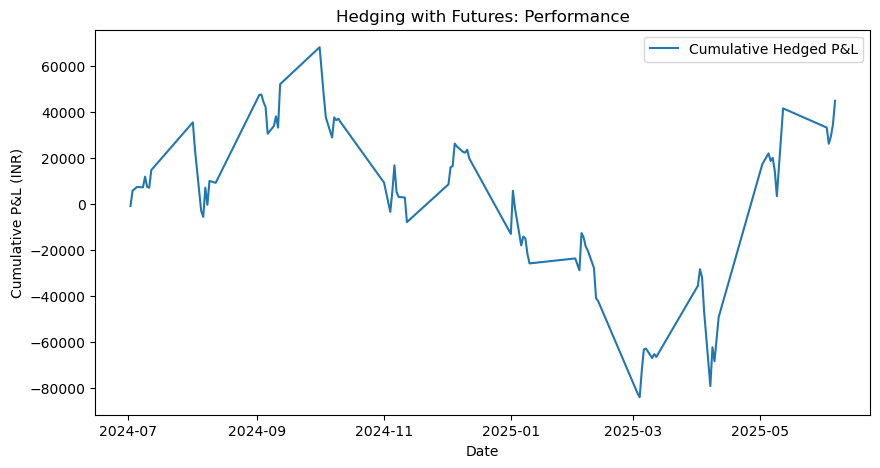

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Cumulative_Hedged_PnL'], label='Cumulative Hedged P&L')
plt.title('Hedging with Futures: Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L (INR)')
plt.legend()
plt.show()